# Turing version


Goal is to make this match the sunode version and test. So far this is just copied from https://turinglang.org/v0.30/tutorials/10-bayesian-differential-equations/

As in the sunode version, we will use both pred and prey observations

In [1]:
using Turing
using DifferentialEquations

# Load StatsPlots for visualizations and diagnostics.
using StatsPlots

using LinearAlgebra

# Set a seed for reproducibility.
using Random
Random.seed!(14);

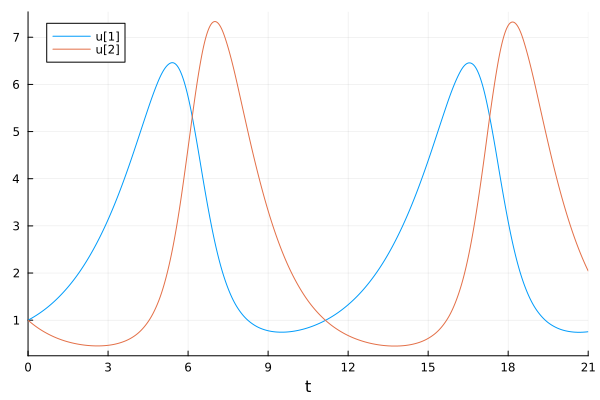

In [2]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end

# Define initial-value problem.
u0 = [1.0, 1.0]
p = [.5,.2,.8,.3]
tspan = (0.0, 21.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p)

# Plot simulation.
plot(solve(prob,  TRBDF2()))

Data from the Sunode version

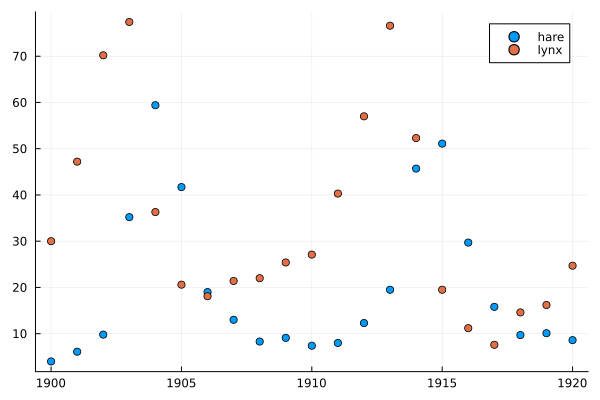

In [3]:
time = collect(range(1900, 1920))
lynx_data = [
    4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
    8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6
]
hare_data = [
    30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4,
    27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7
]
scatter(time, lynx_data, label="hare")
scatter!(time, hare_data, label="lynx")

In [4]:
odedata = collect(transpose(hcat(hare_data, lynx_data)))

2×21 Matrix{Float64}:
 30.0  47.2  70.2  77.4  36.3  20.6  …  19.5  11.2   7.6  14.6  16.2  24.7
  4.0   6.1   9.8  35.2  59.4  41.7     51.1  29.7  15.8   9.7  10.1   8.6

In [5]:
using Distributions

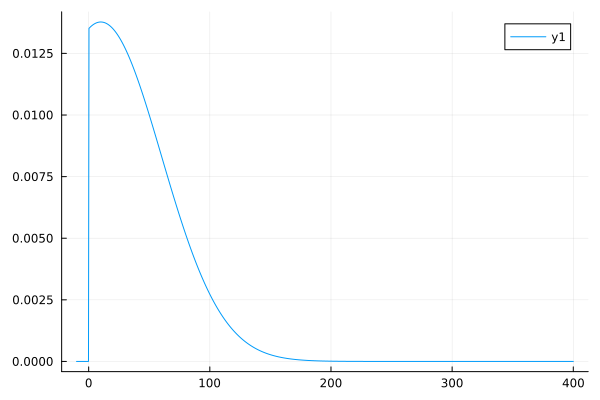

In [6]:
test = truncated(Normal(10,50);lower = 0., upper = Inf)
t= collect(range(-10,400, length = 1000))
plot(t, pdf.(test, t))

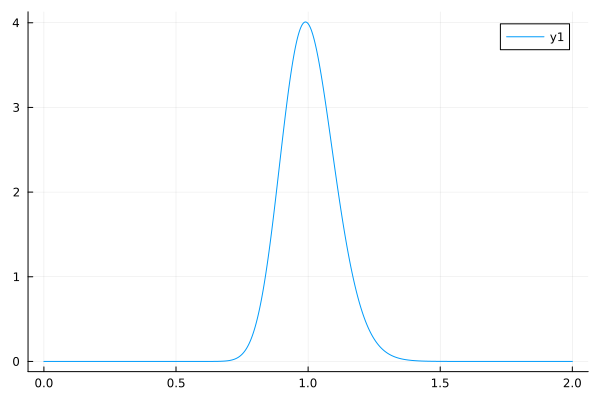

In [7]:
test = LogNormal(0,.1)
t= collect(range(0,2, length = 1000))
plot(t, pdf.(test, t))

In [11]:
@model function fitlv(data, prob)
    # Prior distributions.
    x0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    y0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
     
    # Compute the parameters of the ode based on our prior parameters
    α ~ truncated(Normal(.5, 1); lower=0, upper=2)
    β ~ truncated(Normal(.5, 1); lower=0, upper=2)
    γ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    δ ~ truncated(Normal(.5, 1); lower=0, upper=2)
    σ ~ Exponential(10)
 

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    u0 = [x0, y0]
    predicted = solve(prob,  TRBDF2(); u0=u0, p=p, saveat=time.-1900)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end

fitlv (generic function with 2 methods)

In [8]:
@model function fitlv_2(data, prob)
    # Prior distributions.
    x0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    y0 ~ truncated(Normal(10,50);lower = 0.1, upper = Inf)
    ratio ~ Beta(0.5,0.5)
    fixed_hares ~ truncated(Normal(0,50);lower = 0, upper = Inf)
    fixed_lynx  = fixed_hares * ratio
    period ~ Gamma(100, 0.10) # mean 10, std 1 
    freq = 2 * pi / period

    # Why not use lognormal directly?
    #log_speed_ratio ~ Normal(0,0.1)
    #speed_ratio =  exp(log_speed_ratio)
    speed_ratio ~ LogNormal(0,0.1)

    # Compute the parameters of the ode based on our prior parameters
    α =  freq * speed_ratio * ratio 
    β =  freq * speed_ratio / fixed_hares
    γ =  freq / speed_ratio / ratio
    δ =  freq / speed_ratio / fixed_hares / ratio
    σ ~ truncated(Normal(0,1);lower = 0, upper = Inf)
 

    # Simulate Lotka-Volterra model. 
    p = [α, β, γ, δ]
    u0 = [x0, y0]
    predicted = solve(prob,  TRBDF2(); u0=u0, p=p, saveat=time.-1900)

    # Observations.
    for i in 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ^2 * I)
    end

    return nothing
end


fitlv (generic function with 2 methods)

TODO:   Figure out how to keep it from erroring . With the un-reparammeterized version, it is fine and fast.  So perhaps redo sunode that way too and screw it.

In [12]:

model = fitlv(odedata, prob)


DynamicPPL.Model{typeof(fitlv), (:data, :prob), (), (), Tuple{Matrix{Float64}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCache{Nothing, Nothing, Nothing}}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}}, Tuple{}, DynamicPPL.DefaultContext}(fitlv, (data = [30.0 47.2 … 16.2 24.7; 4.0 6.1 … 10.1 8.6], prob = ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(lotka_volterra), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, SymbolicIndexingInterface.SymbolCach

In [13]:

# Sample 4 independent chains with forward-mode automatic differentiation (the default).
chain = sample(model, NUTS(), MCMCSerial(), 1000, 4,progress=false)

┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191


┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /Users/ronaldlegere/.julia/packages/Turing/tdsVz/src/mcmc/hmc.jl:191


┌ Warning: dt(3.552713678800501e-15) <= dtmin(3.552713678800501e-15) at t=20.06562819163777, and step error estimate = 4.254156489018595e-14. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ SciMLBase /Users/ronaldlegere/.julia/packages/SciMLBase/cL99i/src/integrator_interface.jl:589


Chains MCMC chain (1000×19×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 73.71 seconds
Compute duration  = 73.33 seconds
parameters        = x0, y0, α, β, γ, δ, σ
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

          x0   34.7912    1.7420    0.0387   2025.6961   2059.7838    1.0017   ⋯
          y0    3.8647    0.6919    0.0206   1118.2627   1444.3691    1.0051   ⋯
           α    0.4850    0.0419    0.0014    949.0425   1366.7155    1.0041   ⋯
           β    0.0250    0.0019    0.0000   1437.4407   1861.5089    1.0021   ⋯
           γ    0.9312    0.0868    0.0029    928.4

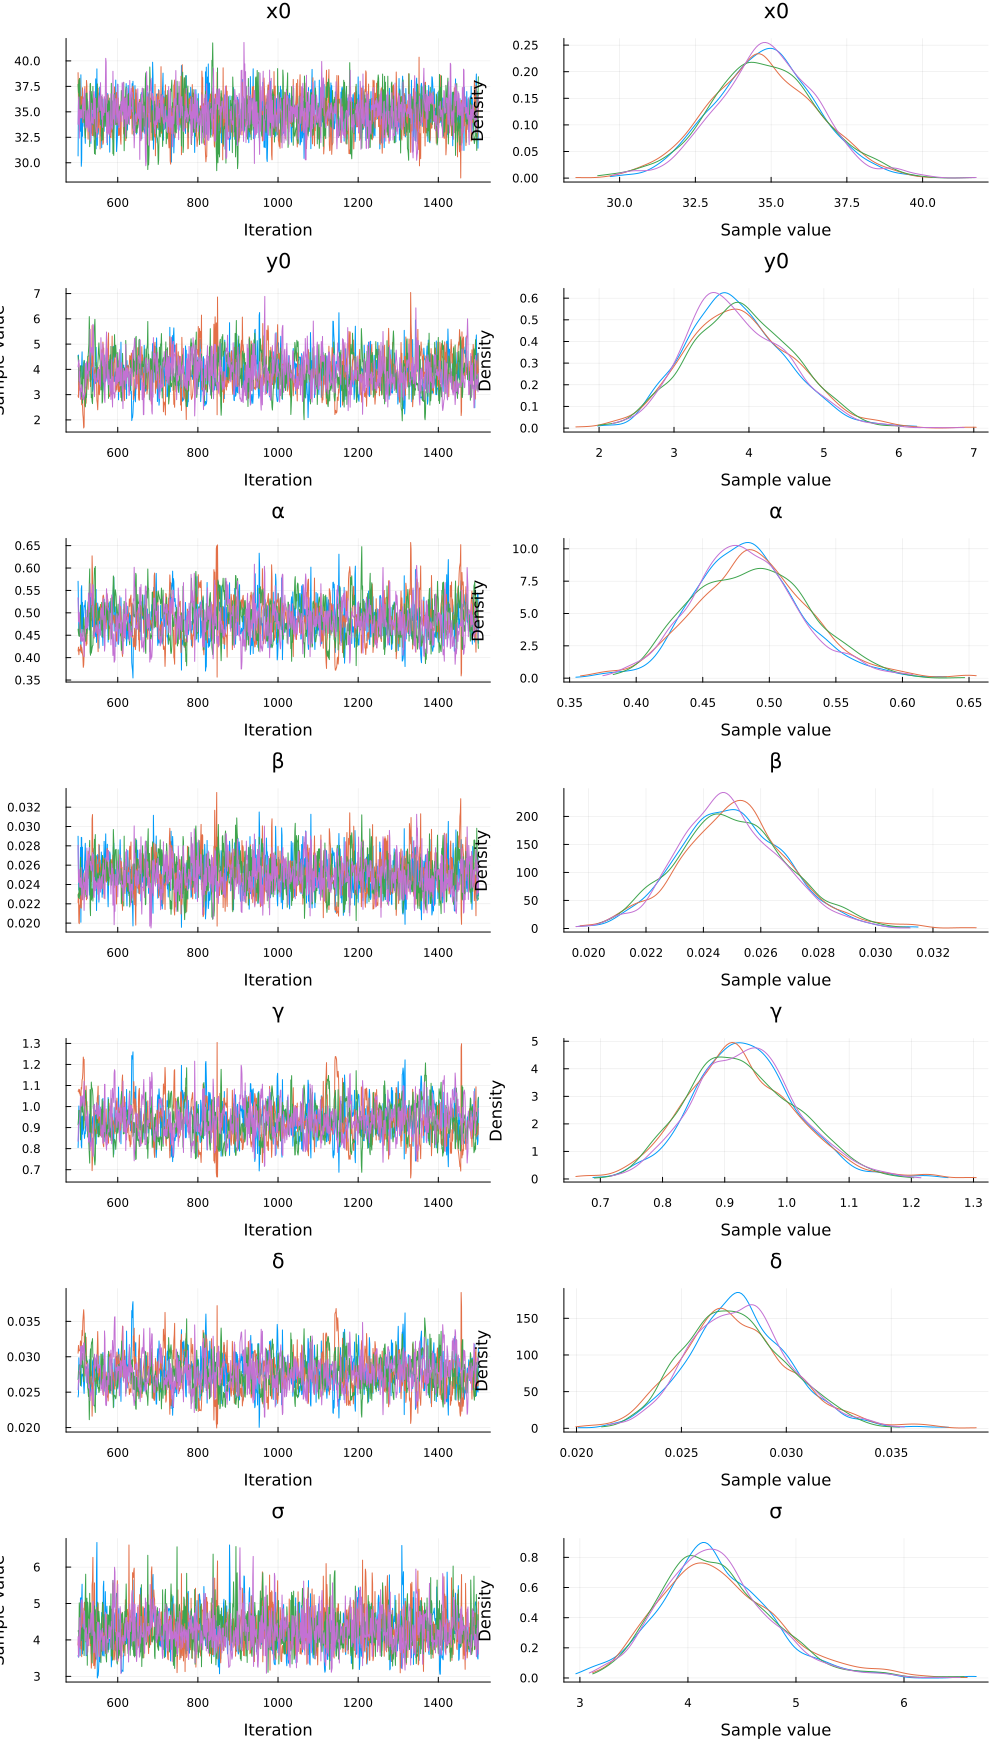

In [14]:
plot(chain)

# This below needs to be fixed to match with the above

In [15]:
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)

Chains MCMC chain (300×6×1 Array{Float64, 3}):

Iterations        = 1:300
Number of chains  = 1
Samples per chain = 300
Wall duration     = 73.71 seconds
Compute duration  = 73.33 seconds
parameters        = x0, y0, α, β, γ, δ
internals         = 

Summary Statistics
  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

          x0   34.7097    1.6106    0.1081   221.9823   231.1514    1.0006     ⋯
          y0    3.8971    0.7150    0.0462   253.0339   287.5241    0.9986     ⋯
           α    0.4872    0.0425    0.0031   208.3416   154.6873    1.0016     ⋯
           β    0.0249    0.0018    0.0001   213.6957   248.1442    1.0076     ⋯
           γ    0.9284    0.0877    0.0058   226.6822   162.9519    1.0014     ⋯
           δ    0.0276    0.0025    0.0002   237.1102   257.4716    1.0014     ⋯
                                                                1 column omitted

Q

In [12]:
Array(posterior_samples)[1,:][3:end]

4-element Vector{Float64}:
 0.9227523433246577
 0.04036781096230868
 0.4587353499519208
 0.014394677448507677

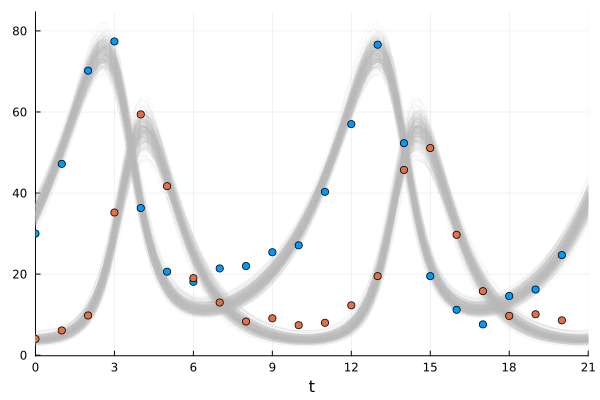

In [16]:
plot(; legend=false)
posterior_samples = sample(chain[[:x0,:y0,:α, :β, :γ, :δ]], 300; replace=false)
for row in eachrow(Array(posterior_samples))
    u0 = row[1:2]
    p = row[3:end]
    sol_p = solve(prob, Tsit5();u0=u0, p=p, saveat=0.2)
    plot!(sol_p; alpha=0.1, color="#BBBBBB")
end

# Plot simulation and noisy observations.
#plot!(sol; color=[1 2], linewidth=1)
scatter!(time.-1900, odedata'; color=[1 2])